# Normalize Data for first Pipeline

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 500)

In [7]:
cont_min_max_scaled = pd.read_csv('cont_min_max_scaled_standardized.csv')
categorical_df = pd.read_csv('categorical_df_standardized.csv')

FileNotFoundError: [Errno 2] File b'cont_min_max_scaled_standardized.csv' does not exist: b'cont_min_max_scaled_standardized.csv'

# Step 7: Check Normality of fields

- Histogram
- Skew

In [8]:
def check_normal_by_hist(df, col):
    '''
    Creates a histogram to view values to check normality
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    Void, however will print a histogram
    
    '''
    df[col].hist()
    plt.title(col)
    plt.show()
    
def check_normal_by_shapiro(df, col):
    '''
    Runs the Shapiro normality test on the values from a dataframe
    
    params:
    df - DataFrame
    col - Columns of DataFrame you want to test
    
    return:
    tuple - (Test Statistic, p-value)
    
    A p-value lower than 0.05 implies the values are NOT normal
    
    '''
    
    return shapiro(df[col].values)

def check_skew(df, col):
    return skew(df[col])

def bad_skew(df, col_list):
    bad_ones = []
    skews = []
    for i in col_list:
        skw = skew(df[i])
        if (skw > 0.5) or (skw < -0.5):
            bad_ones.append(i)
            skews.append(skw)
    return bad_ones, skews
    

In [9]:
cont_min_max_scaled.drop(columns = ['Unnamed: 0'], inplace = True)

NameError: name 'cont_min_max_scaled' is not defined

In [5]:
bad_fields, bad_skew = bad_skew(cont_min_max_scaled, cont_min_max_scaled.columns.tolist()[:-1])

NameError: name 'cont_min_max_scaled' is not defined

Most of those standardized through an IQR cut seem normal. However, will attempt to normalize both sets.

In [6]:
def normalize_log(col_vals):
    return np.log(col_vals + min(col_vals))

def normalize_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return np.sqrt(col_vals)

def normalize_recip_sqrt(col_vals):
    if min(col_vals) < 0:
        print('Can\'t sqrt with negative values')
        return
    return 1/np.sqrt(col_vals)

def normalize_sigmoid(col_vals):
    return [1/(1+np.e**(-i)) for i in col_vals]

def normalize_div(col_vals):
    return 1/col_vals

def normalize_log_div(col_vals):
    return 1/np.log(col_vals + min(col_vals))

def normalize_shift_left(col_vals):
    return col_vals - len(col_vals)

def normalize_shift_right(col_vals):
    return col_vals + len(col_vals)

def normalize_by_power(col_vals):
    return [i**2 for i in col_vals]

def normalize_by_e(col_vals):
    return [np.e **(i + min(col_vals)) for i in col_vals]

def normalize_data(df, col, normalize_function = None):
    '''
    Given a dataframe, column, and type of normalization, attempt to make the field normal.
    
    params:
    df - dataframe
    col - string - column to normalize
    normalize_function - function - type of normalization to perform. If blank then all will be performed and compared.
        options are functions above
        
    '''
    
    if normalize_function is not None:
        try:
            new_vals = normalize_function(df[col].values)
            p_val = shapiro(new_vals)[1]
            valid = 'Normal' if p_val > 0.05 else 'Non-Normal'
            print('Shapiro Test says given function made the data ' + valid +' with a p-value of ' + str(p_val))
            if p_val > 0.05:
                plt.hist(new_vals)
                return True
            else:
                return False
        except Exception as e:
            print(e)

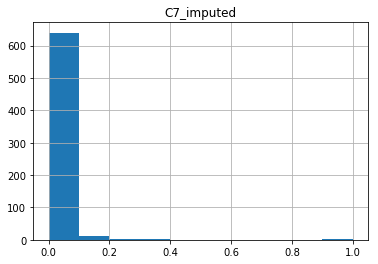

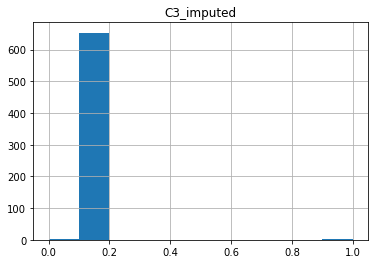

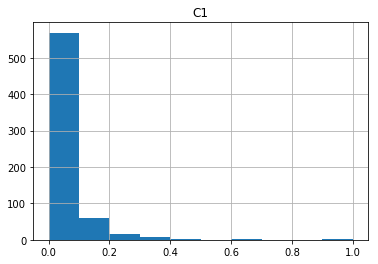

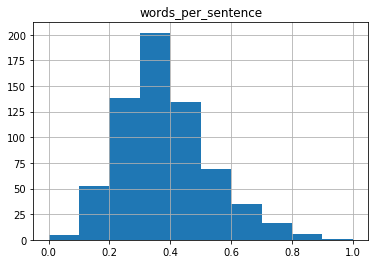

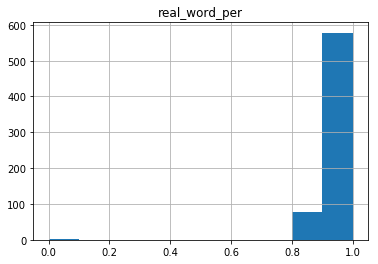

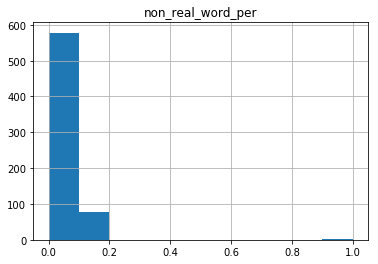

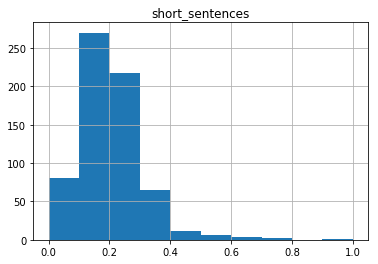

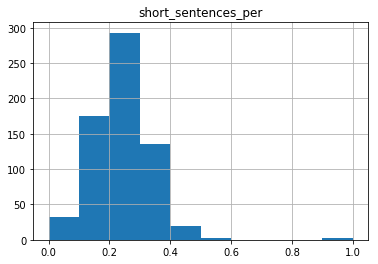

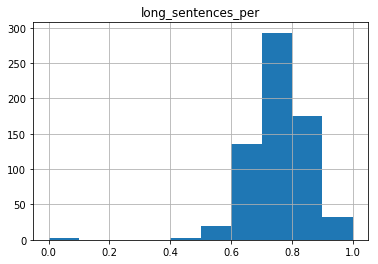

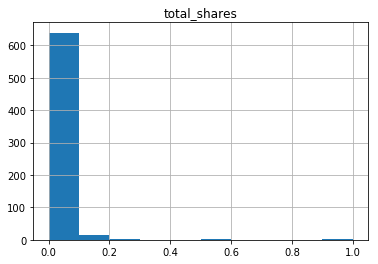

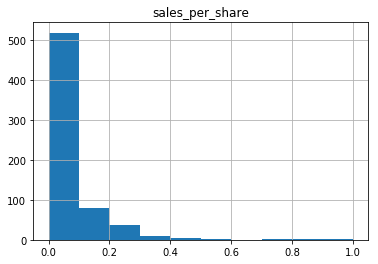

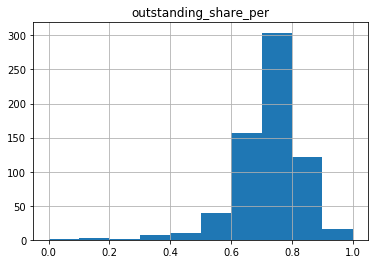

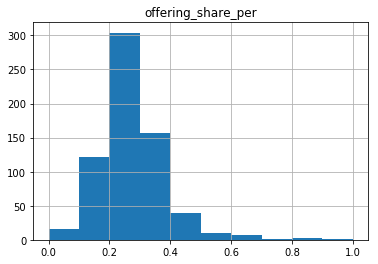

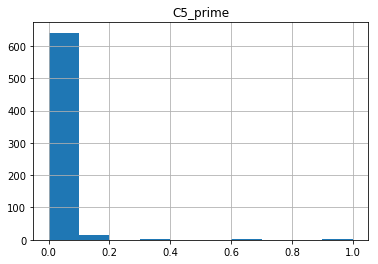

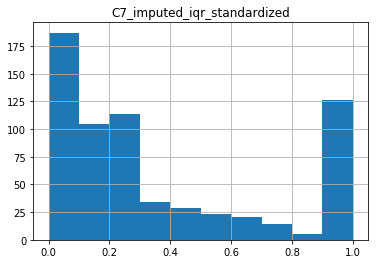

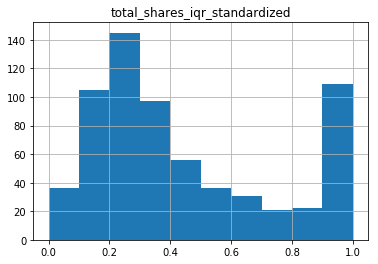

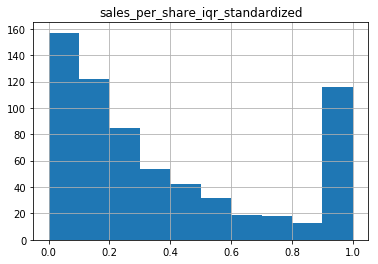

In [7]:
for i in bad_fields:
    cont_min_max_scaled[i].hist()
    plt.title(i)
    plt.show()

In [8]:
#np.log(cont_min_max_scaled[bad_fields[0]]).values

In [8]:
norm = preprocessing.Normalizer()

In [9]:
norm_vals = norm.fit_transform(cont_min_max_scaled[bad_fields].values)
norm_vals = pd.DataFrame(norm_vals)
norm_vals.columns = bad_fields

In [10]:
norm_l2 = []
for i in norm_vals.columns:
    print(skew(norm_vals[i]))
    norm_l2.append(skew(norm_vals[i]))

11.266588832539895
12.473079693970984
4.858798718294804
0.5846005627927316
-1.5175928426258278
11.179489252158321
1.6763611738363324
0.9872875747133568
-1.2129863391046118
12.866790540278213
3.2830716546519922
-1.048096258822256
1.249918874162214
12.066894507250664
0.6609677380921555
0.545354183120935
0.5648063278788467


In [11]:
norm_2 = preprocessing.Normalizer(norm = 'l1')
norm_vals_2 = norm_2.fit_transform(cont_min_max_scaled[bad_fields].values)
norm_vals_2 = pd.DataFrame(norm_vals_2)
norm_vals_2.columns = bad_fields

norm_l1 = []
for i in norm_vals_2.columns:
    print(skew(norm_vals_2[i]))
    norm_l1.append(skew(norm_vals_2[i]))

10.785917401184763
8.425274654532458
4.415460058166325
0.7331372846803216
-0.7233513720790131
10.904858836235638
1.6869400719803016
1.111959946438837
-0.4967082547621151
12.92123786677347
3.156522359929294
-0.5831379230145974
1.4344885996991024
11.547691231408551
0.641194786794722
0.6307043276424911
0.5630659904936134


In [12]:
norm_3 = preprocessing.Normalizer(norm = 'max')
norm_vals_3 = norm_3.fit_transform(cont_min_max_scaled[bad_fields].values)
norm_vals_3 = pd.DataFrame(norm_vals_3)
norm_vals_3.columns = bad_fields

norm_max = []
for i in norm_vals_3.columns:
    print(skew(norm_vals_3[i]))
    norm_max.append(skew(norm_vals_3[i]))

12.130121401456764
20.03273247644083
5.360481268864527
0.6874305061017365
-10.023367416277353
11.308461535451213
1.8081099390334856
1.3106539907527697
-1.5002731897451902
13.293475721076224
3.6503460298653034
-1.6380331380888853
1.4401517818182301
13.121364395443623
0.8136312556464863
0.6532986551273601
0.7065266849863008


In [13]:
norm_compare = pd.DataFrame()
norm_compare['field'] = bad_fields
norm_compare['orig'] = bad_skew
norm_compare['l2'] = norm_l2
norm_compare['l1'] = norm_l1
norm_compare['max'] = norm_max

In [14]:
norm_compare

,field,orig,l2,l1,max
0,C7_imputed,12.118756,11.266589,10.785917,12.130121
1,C3_imputed,21.644949,12.473080,8.425275,20.032732
2,C1,5.645270,4.858799,4.415460,5.360481
3,words_per_sentence,0.645238,0.584601,0.733137,0.687431
4,real_word_per,-11.914035,-1.517593,-0.723351,-10.023367
5,non_real_word_per,11.914035,11.179489,10.904859,11.308462
6,short_sentences,1.922420,1.676361,1.686940,1.808110
7,short_sentences_per,1.587540,0.987288,1.111960,1.310654
8,long_sentences_per,-1.587540,-1.212986,-0.496708,-1.500273
9,total_shares,13.272164,12.866791,12.921238,13.293476


In [15]:
pwr_trs = preprocessing.power_transform(cont_min_max_scaled[bad_fields].values, method = 'yeo-johnson')

#pwr_trs = pwr_transform.fit_transform(cont_min_max_scaled[bad_fields].values)
pwr_trs = pd.DataFrame(pwr_trs)
pwr_trs.columns = bad_fields

pwr_norm = []
for i in pwr_trs.columns:
    #print(skew(pwr_trs[i]))
    pwr_norm.append(skew(pwr_trs[i]))

In [16]:
norm_compare['yeo_johnson'] = pwr_norm

In [17]:
norm_compare

,field,orig,l2,l1,max,yeo_johnson
0,C7_imputed,12.118756,11.266589,10.785917,12.130121,1.177750
1,C3_imputed,21.644949,12.473080,8.425275,20.032732,-4.311614
2,C1,5.645270,4.858799,4.415460,5.360481,0.223750
3,words_per_sentence,0.645238,0.584601,0.733137,0.687431,-0.003875
4,real_word_per,-11.914035,-1.517593,-0.723351,-10.023367,-0.208031
5,non_real_word_per,11.914035,11.179489,10.904859,11.308462,-0.002306
6,short_sentences,1.922420,1.676361,1.686940,1.808110,-0.009862
7,short_sentences_per,1.587540,0.987288,1.111960,1.310654,-0.064187
8,long_sentences_per,-1.587540,-1.212986,-0.496708,-1.500273,0.110705
9,total_shares,13.272164,12.866791,12.921238,13.293476,0.643046


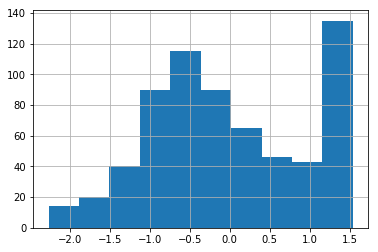

In [18]:
pwr_trs['total_shares_iqr_standardized'].hist()
plt.show()

In [19]:
all_skew = pd.DataFrame()

In [20]:
pwr_transgorm_all = preprocessing.power_transform(cont_min_max_scaled[cont_min_max_scaled.columns[:-1]].values, 
                                                  method = 'yeo-johnson')

pwr_transgorm_all = pd.DataFrame(pwr_transgorm_all)
pwr_transgorm_all.columns = cont_min_max_scaled.columns[:-1]

pwr_norm_all = []
for i in pwr_transgorm_all.columns:
    #print(skew(pwr_trs[i]))
    pwr_norm_all.append(skew(pwr_transgorm_all[i]))

In [21]:
normal_skew = skew(cont_min_max_scaled[cont_min_max_scaled.columns[:-1]])

In [22]:
all_skew['yeo'] = pwr_norm_all
all_skew['orig'] = normal_skew

In [23]:
all_skew

,yeo,orig
0,1.177750,12.118756
1,-4.311614,21.644949
2,0.223750,5.645270
3,-0.012690,-0.474540
4,-0.003875,0.645238
5,-0.208031,-11.914035
6,-0.002306,11.914035
7,-0.009862,1.922420
8,-0.064187,1.587540
9,0.110705,-1.587540


This made every one of them better so will use this for all...

Create the new data

In [24]:
pwr_transgorm_all = preprocessing.power_transform(cont_min_max_scaled[cont_min_max_scaled.columns[:-1]].values, 
                                                  method = 'yeo-johnson')

In [25]:
pwr_transgorm_all = pd.DataFrame(pwr_transgorm_all)

In [26]:
pwr_transgorm_all.columns = cont_min_max_scaled.columns[:-1]

In [27]:
pwr_transgorm_all['I1'] = cont_min_max_scaled['I1'].values

In [28]:
pwr_transgorm_all

,C7_imputed,C3_imputed,C1,C4,words_per_sentence,real_word_per,non_real_word_per,short_sentences,short_sentences_per,long_sentences_per,long_words_per,pos_words_percent,neg_words_percent,uncertain_words_percent,total_shares,sales_per_share,outstanding_share_per,offering_share_per,C5_prime,C6_prime,C7_imputed_iqr_standardized,C3_imputed_iqr_standardized,C1_iqr_standardized,C4_iqr_standardized,words_per_sentence_iqr_standardized,real_word_per_iqr_standardized,non_real_word_per_iqr_standardized,short_sentences_iqr_standardized,short_sentences_per_iqr_standardized,long_sentences_per_iqr_standardized,long_words_per_iqr_standardized,pos_words_percent_iqr_standardized,neg_words_percent_iqr_standardized,uncertain_words_percent_iqr_standardized,total_shares_iqr_standardized,sales_per_share_iqr_standardized,outstanding_share_per_iqr_standardized,offering_share_per_iqr_standardized,C5_prime_iqr_standardized,C6_prime_iqr_standardized,I1
0,-0.691434,0.108864,0.086113,0.629704,0.041299,0.612850,-0.599529,0.131589,-0.097866,0.105567,0.278412,-0.135878,0.318737,-0.132664,0.331150,-0.911508,0.081001,-0.075282,0.053074,0.815008,-0.749334,2.002837,0.117542,0.660016,0.034692,0.680953,-0.663963,0.089527,-0.166119,0.178117,0.347083,-0.146485,0.326454,-0.138303,0.502584,-0.951439,0.139724,-0.127188,0.043286,0.920862,AATI
1,-0.840372,0.047911,1.450244,-0.677739,0.188283,0.108695,-0.085365,1.520798,-0.158645,0.167307,-0.107345,-1.455280,1.209067,-0.218605,-0.434437,-0.980591,2.317859,-2.339497,2.421079,-0.366603,-1.078969,-1.413162,1.587033,-0.690303,0.193808,0.126511,-0.108971,1.834341,-0.230234,0.242024,-0.094205,-1.523188,1.282176,-0.230157,-0.376799,-1.038366,2.201454,-2.265930,1.745398,-0.448096,ABPI
2,-0.953758,0.052508,-0.481282,0.352891,-0.236107,0.637826,-0.625324,-2.042671,-0.047664,0.054521,1.299780,2.902532,-1.890231,-0.792039,-0.885990,-1.195194,-0.236381,0.233961,-0.269124,-2.328362,-1.352968,-1.052474,-0.527822,0.383406,-0.260820,0.707630,-0.691089,-1.931016,-0.112730,0.124823,1.480547,1.903548,-1.921421,-0.842966,-0.938587,-1.314705,-0.217267,0.226597,-0.308389,-2.056332,ACAD
3,-0.946628,0.056499,1.097849,0.330411,-0.569788,1.063992,-1.070142,-0.184971,1.154914,-1.175017,1.281512,1.909651,-1.532206,-0.068066,-1.017807,-1.148951,-0.284567,0.280817,-0.317181,-1.036143,-1.335109,-0.735306,1.544435,0.360737,-0.608578,1.152023,-1.150089,-0.243096,1.298421,-1.307473,1.460682,1.903548,-1.567295,-0.069255,-1.110002,-1.254330,-0.273287,0.281867,-0.359440,-1.170267,ACHN
4,1.332959,0.068342,-0.688275,-1.252107,-0.318397,-0.344315,0.365981,1.061256,0.597528,-0.604463,-0.490515,-0.515221,0.587675,-0.147577,-0.112920,1.627844,-0.003092,0.006788,-0.033257,0.494408,1.495368,0.225996,-0.747158,-1.322286,-0.347335,-0.399222,0.405947,1.191352,0.610687,-0.603937,-0.540619,-0.548837,0.611765,-0.154241,0.002182,1.498650,0.047082,-0.035090,-0.052653,0.537671,ACLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,-0.010444,0.063026,1.731597,-0.151723,-0.675314,1.293727,-1.313579,0.714411,0.277225,-0.276757,-0.214205,0.617969,-0.746499,0.359997,0.216771,0.048652,0.139655,-0.132595,0.113697,1.275791,0.413957,-0.209021,1.587033,-0.133249,-0.716928,1.383504,-1.395233,0.754473,0.242604,-0.231618,-0.217864,0.672034,-0.777286,0.388348,0.375882,0.169660,0.203554,-0.190773,0.111471,1.486758,ZIP
654,-0.843225,0.062543,-0.326509,1.689798,0.274334,0.475601,-0.458322,0.229916,-0.192968,0.202142,0.620124,-0.233896,-0.028794,0.306817,-0.083168,-1.061224,0.518328,-0.504357,0.512848,-0.487249,-1.085609,-0.248300,-0.358770,1.679326,0.287821,0.533057,-0.514347,0.196572,-0.266192,0.277821,0.731678,-0.251017,-0.038128,0.331493,0.036480,-1.141056,0.601112,-0.589543,0.579603,-0.581121,ZLTQ
655,-0.668143,0.074743,-0.076926,0.675353,0.042512,-0.296965,0.319279,-0.862017,-0.201265,0.210560,-0.567681,-0.399404,0.605792,-0.251027,-1.283632,0.028136,-0.036067,0.038940,

In [29]:
pwr_transgorm_all.columns = [i + '_normalized' for i in list(pwr_transgorm_all.columns)]

In [30]:
pwr_transgorm_all.to_csv('normalized_continuous.csv')